In [2]:
import numpy as np
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
df = pd.read_csv(os.getcwd()+"/day.csv")
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


1. Dropping **Instant** as it is just an index comlumn
2. Dropping **dteday** as all relevant information is already captured in other columns
3. Dropping **casual** and **registered** columns as this information will be available untill end of the day. Also, the information is for analysis purpose is available in **cnt** column.

In [4]:
df.drop(["instant","dteday", "casual", "registered"], axis=1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


### **Data cleaning**

In [5]:
#Checking null values
df.isnull().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

There are no null values.

In [6]:
#Checking the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


All columns seem to be in correct data type

In [7]:
#Checking value counts
df.workingday.value_counts()

1    499
0    231
Name: workingday, dtype: int64

`season`, `yr`, `mnth`, `holiday`, `weekday`, `workingday` and `weathersit` are categorical variables. 

In [8]:
df.season.replace({1:"Spring", 2:"Summer", 3:"Fall", 4:"Winter"},inplace = True)
df.weathersit.replace({1:'Good',2:'Moderate',3:'Bad',4:'Severe'},inplace = True)
df.mnth.replace({1: 'Jan',2: 'Feb',3: 'Mar',4: 'Apr',5: 'May',6: 'Jun',7: 'Jul',8: 'Aug',9: 'Sep',10: 'Oct',11: 'Nov',12: 'Dec'}, inplace = True)
df.weekday.replace({0: 'Sun',1: 'Mon',2: 'Tue',3: 'Wed',4: 'Thu',5: 'Fri',6: 'Sat'}, inplace = True)
df.holiday.replace({0:'No', 1:'Yes'}, inplace = True)
df.workingday.replace({0:'No', 1:'Yes'}, inplace = True)
df.yr.replace({0:'2018', 1:'2019'}, inplace = True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,No,Sat,No,Moderate,14.110847,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,No,Sun,No,Moderate,14.902598,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,No,Mon,Yes,Good,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,No,Tue,Yes,Good,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,No,Wed,Yes,Good,9.305237,11.46350,43.6957,12.522300,1600


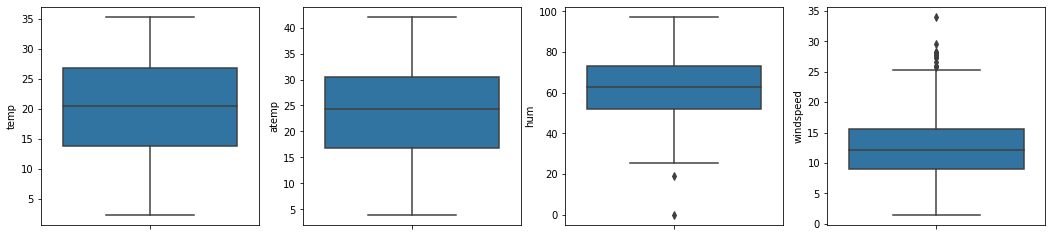

In [9]:
# temp, atemp, hum and windspeed and cnt are continuours variables
# checking for outliers in the same
cols = ['temp', 'atemp', 'hum', 'windspeed']
plt.figure(figsize=(18,4))

i = 1
for col in cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=df)
    i+=1

There are some outliers in `hum` and `windspeed`.

### Data understanding

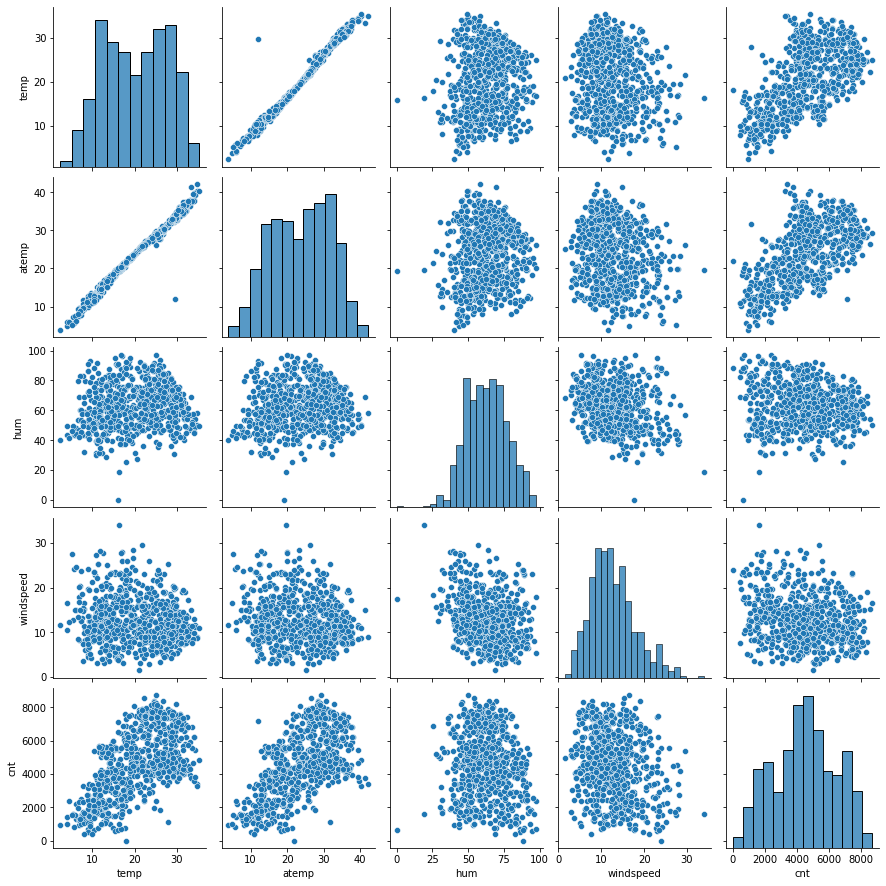

In [10]:
#Checking corrleation between numeric variables.
sns.pairplot(data=df.iloc[:, 7:])

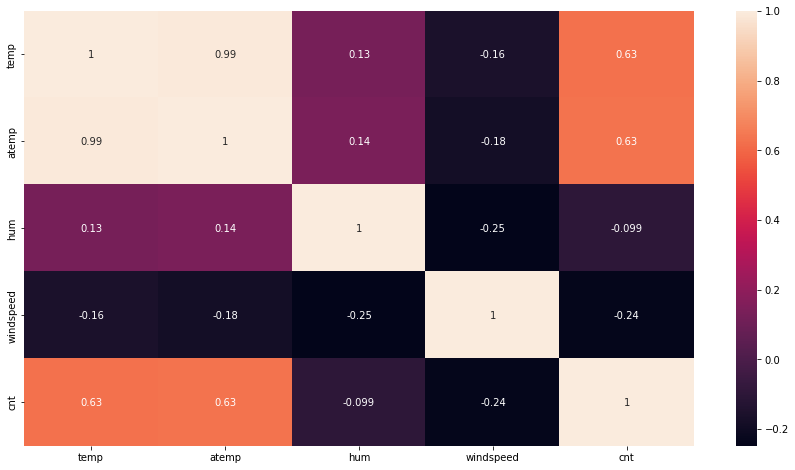

In [11]:
# Finding correlation between all numeric features
plt.figure(figsize=(15,8))
sns.heatmap(df[['temp', 'atemp', 'hum', 'windspeed', 'cnt']].corr(), annot=True)

1. For obvious reasons there is very high correlation between `temp` and `atemp` i.e. 0.99. Therefore, it is fine to **drop the temp column.**
2. `cnt` and temperatures columns also have positive correlation which indicates, **people tend to use bikes more when it is warm outside**.

---





In [12]:
#dropping temp column as per conclusion above
df.drop(['temp'], axis=1, inplace=True)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt
0,Spring,2018,Jan,No,Sat,No,Moderate,18.18125,80.5833,10.749882,985
1,Spring,2018,Jan,No,Sun,No,Moderate,17.68695,69.6087,16.652113,801
2,Spring,2018,Jan,No,Mon,Yes,Good,9.47025,43.7273,16.636703,1349
3,Spring,2018,Jan,No,Tue,Yes,Good,10.60610,59.0435,10.739832,1562
4,Spring,2018,Jan,No,Wed,Yes,Good,11.46350,43.6957,12.522300,1600


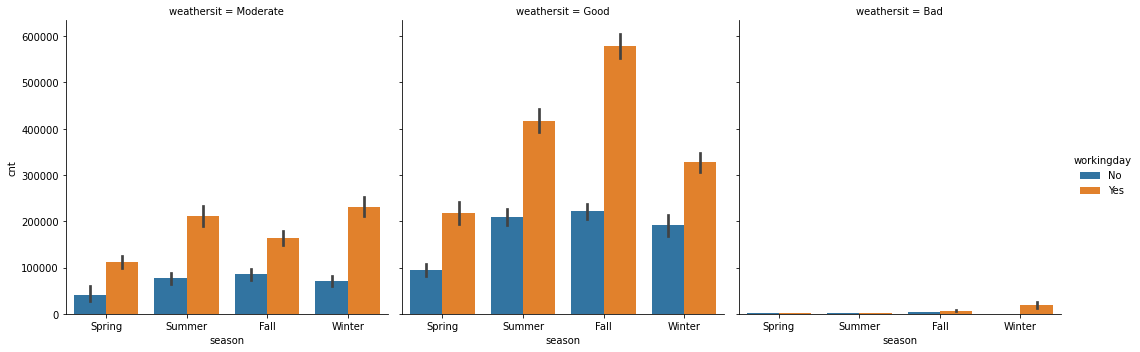

In [13]:
sns.catplot(data=df, x="season", y="cnt", hue='workingday', col='weathersit', kind='bar', estimator=sum)

From above chart it is clear that:
1. Mostly bikers prefer Good weather conditions
2. Higher usage of bikes is seen on a working day as compared to a non working day

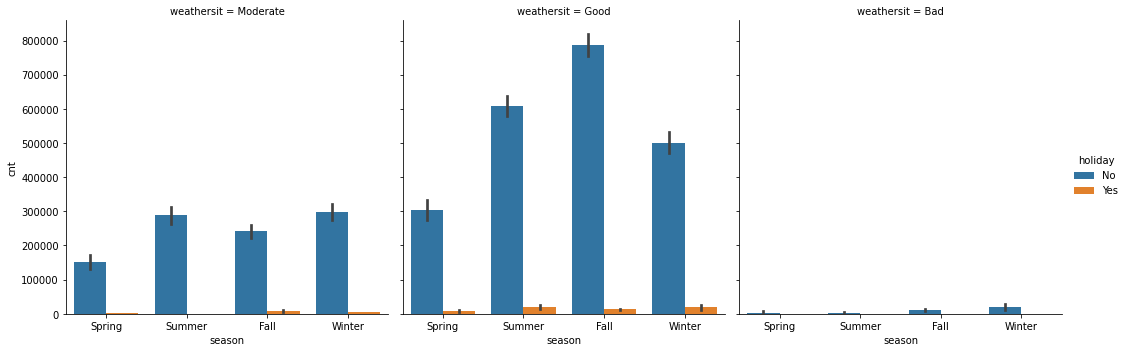

In [14]:
sns.catplot(data=df, x="season", y="cnt", hue='holiday', col='weathersit', kind='bar', estimator=sum)

On the similar lines as above, bike usage is very high on a non holiday day. It is also necessary to note that in a year there are not many holidays.

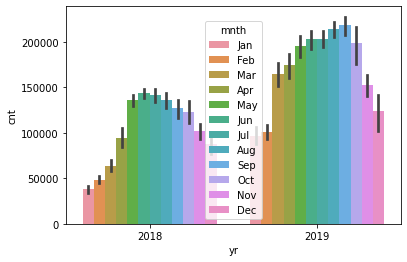

In [15]:
sns.barplot(data=df, x='yr', y='cnt', hue='mnth', estimator=sum)

Above graph clearly shows that there is a **increase in usage of bike in 2019 as compared to 2018**.

Most usage of bike are seen in **May-Oct**.

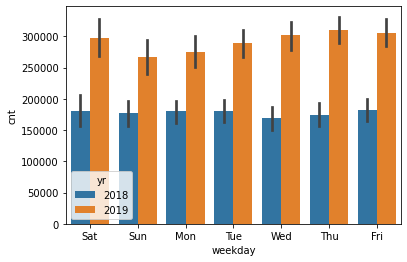

In [16]:
sns.barplot(data=df, x='weekday', y='cnt', hue='yr', estimator=sum)

Again if we compare usage of bikes on **weekday** basis, there is **not much variation**.

This graph also shows that there is a signification amount of **increase in bike usage in 2019 as compared to 2018**.

### Summary
Major influencing factors are
1. weathersit = Good
2. season = Fall
3. workingday = yes
4. mnth = May-Oct
5. atemp has positive correlation with number of bikers


## Data preparation for Linear regression

In [17]:
#creating instance of one-hot-encoder
encoder = OneHotEncoder(handle_unknown='ignore')

#perform one-hot encoding on 'season' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['season']]).toarray())

#renaming column names
encoder_df.columns = ['Season_Fall', 'Season_Spring', 'Season_Summer', 'Season_Winter']
encoder_df

,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0
...,...,...,...,...
725,0.0,1.0,0.0,0.0
726,0.0,1.0,0.0,0.0
727,0.0,1.0,0.0,0.0
728,0.0,1.0,0.0,0.0


In [18]:
df = df.join(encoder_df)
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter
0,Spring,2018,Jan,No,Sat,No,Moderate,18.18125,80.5833,10.749882,985,0.0,1.0,0.0,0.0
1,Spring,2018,Jan,No,Sun,No,Moderate,17.68695,69.6087,16.652113,801,0.0,1.0,0.0,0.0
2,Spring,2018,Jan,No,Mon,Yes,Good,9.47025,43.7273,16.636703,1349,0.0,1.0,0.0,0.0
3,Spring,2018,Jan,No,Tue,Yes,Good,10.60610,59.0435,10.739832,1562,0.0,1.0,0.0,0.0
4,Spring,2018,Jan,No,Wed,Yes,Good,11.46350,43.6957,12.522300,1600,0.0,1.0,0.0,0.0


In [19]:
#now we can drop the original season column
df.drop(['season'], inplace=True, axis=1)

In [20]:
#perform one-hot encoding on 'yr' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['yr']]).toarray())
encoder_df.columns = ['yr_2018', 'yr_2019']
encoder_df.head()

,yr_2018,yr_2019
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [21]:
df = df.join(encoder_df)

In [22]:
#now we can drop the yr column
df.drop(['yr'], inplace=True, axis=1)

In [23]:
#perform one-hot encoding on 'mnth' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['mnth']]).toarray())
encoder_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [24]:
#checking which column belongs to which month
df = df.join(encoder_df)
print(df[df.mnth == 'Jan'].head(1))
print(df[df.mnth == 'Feb'].head(1))
print(df[df.mnth == 'Mar'].head(1))
print(df[df.mnth == 'Apr'].head(1))
print(df[df.mnth == 'May'].head(1))
print(df[df.mnth == 'Jun'].head(1))
print(df[df.mnth == 'Jul'].head(1))
print(df[df.mnth == 'Aug'].head(1))
print(df[df.mnth == 'Sep'].head(1))
print(df[df.mnth == 'Oct'].head(1))
print(df[df.mnth == 'Nov'].head(1))
print(df[df.mnth == 'Dec'].head(1))

  mnth holiday weekday workingday weathersit     atemp      hum  windspeed  \
0  Jan      No     Sat         No   Moderate  18.18125  80.5833  10.749882   

   cnt  Season_Fall  ...    2    3    4    5    6    7    8    9   10   11  
0  985          0.0  ...  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 27 columns]
   mnth holiday weekday workingday weathersit    atemp      hum  windspeed  \
31  Feb      No     Tue        Yes   Moderate  11.7265  82.9565   3.565271   

     cnt  Season_Fall  ...    2    3    4    5    6    7    8    9   10   11  
31  1360          0.0  ...  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[1 rows x 27 columns]
   mnth holiday weekday workingday weathersit     atemp   hum  windspeed  \
59  Mar      No     Tue        Yes       Good  13.19395  53.5  14.500475   

     cnt  Season_Fall  ...    2    3    4    5    6    7    8    9   10   11  
59  1851          0.0  ...  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  

[1 rows x 27 col

In [25]:
df[(df.mnth == 'Aug')].iloc[:,0:17].head(1)

,mnth,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,yr_2019,0,1
212,Aug,No,Mon,Yes,Good,35.1646,55.0833,10.500039,4266,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [26]:
# Change column names as per observation from above two outputs
df.rename(columns={0:'Apr',
                   1:'Aug',
                   2:'Dec',
                   3:'Feb',
                   4:'Jan',
                   5:'Jul',
                   6:'Jun',
                   7:'Mar',
                   8:'May',
                   9:'Nov',
                   10:'Oct',
                   11:'Sep'}, inplace=True)
df.iloc[:, 15:28].head()

,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
#now mnth column can be dropped
df.drop(['mnth'], inplace=True, axis=1)
df.head()

,holiday,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,...,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,No,Sat,No,Moderate,18.18125,80.5833,10.749882,985,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,No,Sun,No,Moderate,17.68695,69.6087,16.652113,801,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,No,Mon,Yes,Good,9.47025,43.7273,16.636703,1349,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,No,Tue,Yes,Good,10.60610,59.0435,10.739832,1562,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,No,Wed,Yes,Good,11.46350,43.6957,12.522300,1600,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
#perform one-hot encoding on 'holiday' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['holiday']]).toarray())
encoder_df.head()

,0,1
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [29]:
#replacing the column names
encoder_df.columns = ['Holiday_No', 'Holiday_Yes']
encoder_df.head()

,Holiday_No,Holiday_Yes
0,1.0,0.0
1,1.0,0.0
2,1.0,0.0
3,1.0,0.0
4,1.0,0.0


In [30]:
#joining the encoded values with original data frame and deleting the holiday column
df = df.join(encoder_df)
df.drop(columns=['holiday'], inplace=True)
df.head()

,weekday,workingday,weathersit,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,...,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,Holiday_No,Holiday_Yes
0,Sat,No,Moderate,18.18125,80.5833,10.749882,985,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,Sun,No,Moderate,17.68695,69.6087,16.652113,801,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,Mon,Yes,Good,9.47025,43.7273,16.636703,1349,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Tue,Yes,Good,10.60610,59.0435,10.739832,1562,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,Wed,Yes,Good,11.46350,43.6957,12.522300,1600,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [31]:
#perform one-hot encoding on 'workingday' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['workingday']]).toarray())
encoder_df.head()

,0,1
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [32]:
#replacing the column names
encoder_df.columns = ['Workingday_No', 'Workingday_Yes']
encoder_df.head()

,Workingday_No,Workingday_Yes
0,1.0,0.0
1,1.0,0.0
2,0.0,1.0
3,0.0,1.0
4,0.0,1.0


In [33]:
#joining the encoded values with original data frame and deleting the workingday column
df = df.join(encoder_df)
df.drop(columns=['workingday'], inplace=True)
df.head()

,weekday,weathersit,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,...,Jun,Mar,May,Nov,Oct,Sep,Holiday_No,Holiday_Yes,Workingday_No,Workingday_Yes
0,Sat,Moderate,18.18125,80.5833,10.749882,985,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Sun,Moderate,17.68695,69.6087,16.652113,801,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Mon,Good,9.47025,43.7273,16.636703,1349,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,Tue,Good,10.60610,59.0435,10.739832,1562,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,Wed,Good,11.46350,43.6957,12.522300,1600,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [34]:
#perform one-hot encoding on 'weathersit' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['weathersit']]).toarray())
encoder_df.head()

,0,1,2
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [35]:
#replacing the column names
encoder_df.columns = ['WeatherSit_Bad', 'WeatherSit_Good','WeatherSit_Moderate']
encoder_df.head()

,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [36]:
#joining the encoded values with original data frame and deleting the weathersit column
df = df.join(encoder_df)
df.drop(columns=['weathersit'], inplace=True)
df.head()

,weekday,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,...,Nov,Oct,Sep,Holiday_No,Holiday_Yes,Workingday_No,Workingday_Yes,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate
0,Sat,18.18125,80.5833,10.749882,985,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
1,Sun,17.68695,69.6087,16.652113,801,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
2,Mon,9.47025,43.7273,16.636703,1349,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Tue,10.60610,59.0435,10.739832,1562,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Wed,11.46350,43.6957,12.522300,1600,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


In [37]:
#perform one-hot encoding on 'weekday' column 
encoder_df = pd.DataFrame(encoder.fit_transform(df[['weekday']]).toarray())
encoder_df.head(7)

,0,1,2,3,4,5,6
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
df.weekday.head(7)

0    Sat
1    Sun
2    Mon
3    Tue
4    Wed
5    Thu
6    Fri
Name: weekday, dtype: object

In [39]:
#replacing the column names
encoder_df.columns = ['Fri','Mon','Sat','Sun','Thu','Tue','Wed']
encoder_df.head()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [40]:
#joining the encoded values with original data frame and deleting the wwekday column
df = df.join(encoder_df)
df.drop(columns=['weekday'], inplace=True)
df.head()

,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,yr_2019,...,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,18.18125,80.5833,10.749882,985,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,17.68695,69.6087,16.652113,801,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,9.47025,43.7273,16.636703,1349,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10.60610,59.0435,10.739832,1562,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,11.46350,43.6957,12.522300,1600,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Train test split

Since we have significant amount of data, the train test split would be 80:20

In [41]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=50)
print(df_train.shape)
print(df_test.shape)

(510, 36)
(220, 36)


## Rescaling

We will using nomalization method here (Min-Max) scaling

In [42]:
#Initalizing the scaler
scaler = MinMaxScaler()

#Variables to be rescaled
rescale_vars = ['atemp', 'hum', 'windspeed', 'cnt']

#Fit on the data
df_train[rescale_vars] = scaler.fit_transform(df_train[rescale_vars])
df_train.head()

,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,yr_2019,...,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate,Fri,Mon,Sat,Sun,Thu,Tue,Wed
172,0.858891,0.729068,0.274549,0.515992,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
14,0.236172,0.513954,0.243603,0.141049,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
204,1.000000,0.567625,0.267859,0.412333,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
182,0.821838,0.458136,0.150755,0.586401,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
708,0.498080,0.953198,0.313605,0.592269,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


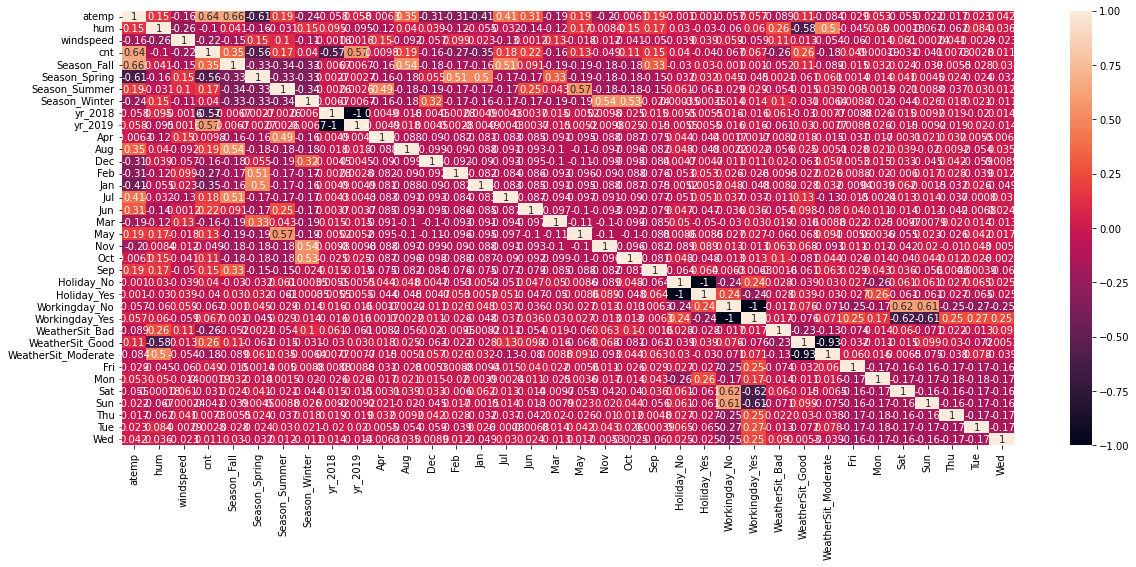

In [43]:
plt.figure(figsize=(20,8))
sns.heatmap(df_train.corr(), annot=True)

## Modelling



### Predictor and dependent variables
We need to divide the data into predictor variables and dependent variables.

In this case `cnt` is the _dependent_ variable while all others are _predictor_ variables.

In [44]:
# dividing the data in predictor (X_train) and dependent (y_train) variables
y_train = df_train.pop('cnt')
X_train = df_train

print(y_train.head())
print(X_train.head())

172    0.515992
14     0.141049
204    0.412333
182    0.586401
708    0.592269
Name: cnt, dtype: float64
        atemp       hum  windspeed  Season_Fall  Season_Spring  Season_Summer  \
172  0.858891  0.729068   0.274549          1.0            0.0            0.0   
14   0.236172  0.513954   0.243603          0.0            1.0            0.0   
204  1.000000  0.567625   0.267859          1.0            0.0            0.0   
182  0.821838  0.458136   0.150755          1.0            0.0            0.0   
708  0.498080  0.953198   0.313605          0.0            0.0            0.0   

     Season_Winter  yr_2018  yr_2019  Apr  ...  WeatherSit_Bad  \
172            0.0      1.0      0.0  0.0  ...             0.0   
14             0.0      1.0      0.0  0.0  ...             0.0   
204            0.0      1.0      0.0  0.0  ...             0.0   
182            0.0      1.0      0.0  0.0  ...             0.0   
708            1.0      0.0      1.0  0.0  ...             0.0   

     Weath

In [45]:
#adding constant to X_train
X_train = sm.add_constant(X_train)

#Creating model
lr = sm.OLS(y_train, X_train)

#fit
lr_model = lr.fit()

#Checking coefficient 
lr_model.params

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


const                  0.117088
atemp                  0.415088
hum                   -0.196007
windspeed             -0.172413
Season_Fall            0.011869
Season_Spring         -0.057494
Season_Summer          0.030500
Season_Winter          0.132212
yr_2018               -0.059106
yr_2019                0.176194
Apr                    0.020760
Aug                    0.038871
Dec                   -0.055671
Feb                   -0.020047
Jan                   -0.046972
Jul                    0.014280
Jun                    0.057343
Mar                    0.017210
May                    0.057704
Nov                   -0.061992
Oct                    0.004624
Sep                    0.090979
Holiday_No             0.078885
Holiday_Yes            0.038202
Workingday_No          0.058292
Workingday_Yes         0.058796
WeatherSit_Bad        -0.084711
WeatherSit_Good        0.124566
WeatherSit_Moderate    0.077232
Fri                    0.033588
Mon                    0.001886
Sat     

In [46]:
print(lr_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.60e-183
Time:                        11:29:43   Log-Likelihood:                 534.94
No. Observations:                 510   AIC:                            -1014.
Df Residuals:                     482   BIC:                            -895.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1171    

### Checking Variance Inflation Factor

In [47]:
vif = pd.DataFrame()
vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by='VIF', ascending = False)
vif

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,Features,VIF
18,May,inf
27,WeatherSit_Good,inf
21,Sep,inf
22,Holiday_No,inf
23,Holiday_Yes,inf
24,Workingday_No,inf
25,Workingday_Yes,inf
26,WeatherSit_Bad,inf
28,WeatherSit_Moderate,inf
19,Nov,inf


In [48]:
#defining a function to remove least significant variable and reanalyse the data
def remove_feature_show_summary(colname):
  X_train.drop(columns=[colname], axis=1, inplace=True)
  lr = sm.OLS(y_train, X_train)
  lr_model = lr.fit()
  print(lr_model.summary())
  vif = pd.DataFrame()
  vif['Features'] = X_train.columns
  vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by='VIF', ascending = False)
  print(vif)
  print(X_train.head())
  return lr_model

From above output, variable `Mon` has highest P value and VIF hence removing the same

In [49]:
lr_model = remove_feature_show_summary('Mon')

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.60e-183
Time:                        11:29:43   Log-Likelihood:                 534.94
No. Observations:                 510   AIC:                            -1014.
Df Residuals:                     482   BIC:                            -895.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1177    

/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


From above output, variable `Oct` has highest P value and VIF hence removing the same

In [50]:
lr_model = remove_feature_show_summary('Oct')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     105.9
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.60e-183
Time:                        11:29:43   Log-Likelihood:                 534.94
No. Observations:                 510   AIC:                            -1014.
Df Residuals:                     482   BIC:                            -895.3
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1192    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


From above output, variable `Jul` has highest P value and VIF hence removing the same

In [51]:
lr_model = remove_feature_show_summary('Jul')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     110.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.56e-184
Time:                        11:29:44   Log-Likelihood:                 534.90
No. Observations:                 510   AIC:                            -1016.
Df Residuals:                     483   BIC:                            -901.5
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1202    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
28                  Sat   inf
9               yr_2019   inf
20           Holiday_No   inf
29                  Sun   inf
21          Holiday_Yes   inf
22        Workingday_No   inf
23       Workingday_Yes   inf
24       WeatherSit_Bad   inf
8               yr_2018   inf
7         Season_Winter   inf
6         Season_Summer   inf
5         Season_Spring   inf
4           Season_Fall   inf
25      WeatherSit_Good   inf
26  WeatherSit_Moderate   inf
1                 atemp  5.58
17                  May  4.65
14                  Jan  4.65
13                  Feb  4.31
16                  Mar  4.05
10                  Apr  3.90
15                  Jun  2.59
12                  Dec  2.50
2                   hum  2.20
18                  Nov  2.04
11                  Aug  1.82
31                  Tue  1.79
30                  Thu  1.76
27                  Fri  1.75
32                  Wed  1.72
19                  Sep  1.49
3             windspeed  1.21
0         

From above output, variable `Mar` has highest P value hence removing the same

In [52]:
lr_model = remove_feature_show_summary('Mar')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     114.8
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.52e-185
Time:                        11:29:44   Log-Likelihood:                 534.84
No. Observations:                 510   AIC:                            -1018.
Df Residuals:                     484   BIC:                            -907.6
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1220    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
27                  Sat   inf
25  WeatherSit_Moderate   inf
24      WeatherSit_Good   inf
4           Season_Fall   inf
5         Season_Spring   inf
6         Season_Summer   inf
7         Season_Winter   inf
8               yr_2018   inf
9               yr_2019   inf
23       WeatherSit_Bad   inf
22       Workingday_Yes   inf
21        Workingday_No   inf
20          Holiday_Yes   inf
28                  Sun   inf
19           Holiday_No   inf
1                 atemp  5.19
16                  May  3.13
10                  Apr  2.48
2                   hum  2.20
14                  Jan  2.11
15                  Jun  2.00
13                  Feb  1.90
17                  Nov  1.87
30                  Tue  1.79
29                  Thu  1.76
12                  Dec  1.76
11                  Aug  1.75
26                  Fri  1.75
31                  Wed  1.72
18                  Sep  1.43
3             windspeed  1.21
0                 const  0.00
     const

From above output, variable `Apr` has highest P value hence removing the same

In [53]:
lr_model = remove_feature_show_summary('Apr')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     119.8
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.41e-186
Time:                        11:29:44   Log-Likelihood:                 534.82
No. Observations:                 510   AIC:                            -1020.
Df Residuals:                     485   BIC:                            -913.8
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1222    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
24  WeatherSit_Moderate   inf
8               yr_2018   inf
19          Holiday_Yes   inf
27                  Sun   inf
20        Workingday_No   inf
21       Workingday_Yes   inf
22       WeatherSit_Bad   inf
18           Holiday_No   inf
9               yr_2019   inf
7         Season_Winter   inf
6         Season_Summer   inf
5         Season_Spring   inf
4           Season_Fall   inf
23      WeatherSit_Good   inf
26                  Sat   inf
1                 atemp  5.19
2                   hum  2.20
13                  Jan  2.11
12                  Feb  1.90
16                  Nov  1.87
15                  May  1.87
29                  Tue  1.79
11                  Dec  1.76
25                  Fri  1.75
28                  Thu  1.75
30                  Wed  1.72
10                  Aug  1.72
14                  Jun  1.50
17                  Sep  1.41
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspee

`Tue` has highest P-value. Hence removing the same

In [54]:
lr_model = remove_feature_show_summary('Tue')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:44   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1230    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
26                  Sat   inf
18           Holiday_No   inf
20        Workingday_No   inf
27                  Sun   inf
21       Workingday_Yes   inf
22       WeatherSit_Bad   inf
23      WeatherSit_Good   inf
9               yr_2019   inf
8               yr_2018   inf
7         Season_Winter   inf
6         Season_Summer   inf
5         Season_Spring   inf
4           Season_Fall   inf
24  WeatherSit_Moderate   inf
19          Holiday_Yes   inf
1                 atemp  5.19
2                   hum  2.20
13                  Jan  2.11
12                  Feb  1.90
16                  Nov  1.87
15                  May  1.87
11                  Dec  1.76
10                  Aug  1.71
14                  Jun  1.49
17                  Sep  1.41
28                  Thu  1.31
25                  Fri  1.30
29                  Wed  1.29
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspeed  Season_Fall  Season_Spring 

`Sat` has very high VIF. Hence removing the same



In [55]:
lr_model = remove_feature_show_summary('Sat')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:44   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1230    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
21       Workingday_Yes   inf
23      WeatherSit_Good   inf
24  WeatherSit_Moderate   inf
4           Season_Fall   inf
5         Season_Spring   inf
6         Season_Summer   inf
7         Season_Winter   inf
8               yr_2018   inf
9               yr_2019   inf
20        Workingday_No   inf
22       WeatherSit_Bad   inf
19          Holiday_Yes   inf
18           Holiday_No   inf
1                 atemp  5.19
2                   hum  2.20
13                  Jan  2.11
12                  Feb  1.90
16                  Nov  1.87
15                  May  1.87
26                  Sun  1.78
11                  Dec  1.76
10                  Aug  1.71
14                  Jun  1.49
17                  Sep  1.41
27                  Thu  1.31
25                  Fri  1.30
28                  Wed  1.29
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspeed  Season_Fall  Season_Spring  \
172    1.0  0.858891  0.729

`Workingday_Yes` has very high VIF. Hence removing the same

In [56]:
lr_model = remove_feature_show_summary('Workingday_Yes')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:44   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.1410    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
22      WeatherSit_Good   inf
23  WeatherSit_Moderate   inf
4           Season_Fall   inf
5         Season_Spring   inf
6         Season_Summer   inf
7         Season_Winter   inf
8               yr_2018   inf
9               yr_2019   inf
21       WeatherSit_Bad   inf
19          Holiday_Yes   inf
18           Holiday_No   inf
1                 atemp  5.19
20        Workingday_No  2.30
2                   hum  2.20
13                  Jan  2.11
12                  Feb  1.90
16                  Nov  1.87
15                  May  1.87
25                  Sun  1.78
11                  Dec  1.76
10                  Aug  1.71
14                  Jun  1.49
17                  Sep  1.41
26                  Thu  1.31
24                  Fri  1.30
27                  Wed  1.29
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspeed  Season_Fall  Season_Spring  \
172    1.0  0.858891  0.729068   0.274549          1.0   

`WeatherSit_Good` has very high VIF. Hence removing the same

In [57]:
lr_model = remove_feature_show_summary('WeatherSit_Good')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:45   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2000    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
4           Season_Fall   inf
5         Season_Spring   inf
6         Season_Summer   inf
7         Season_Winter   inf
8               yr_2018   inf
9               yr_2019   inf
19          Holiday_Yes   inf
18           Holiday_No   inf
1                 atemp  5.19
20        Workingday_No  2.30
2                   hum  2.20
13                  Jan  2.11
12                  Feb  1.90
15                  May  1.87
16                  Nov  1.87
24                  Sun  1.78
11                  Dec  1.76
10                  Aug  1.71
22  WeatherSit_Moderate  1.68
14                  Jun  1.49
17                  Sep  1.41
21       WeatherSit_Bad  1.35
25                  Thu  1.31
23                  Fri  1.30
26                  Wed  1.29
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspeed  Season_Fall  Season_Spring  \
172    1.0  0.858891  0.729068   0.274549          1.0            0.0   
14     1.0  0.

`Season_Fall` has high VIF and comparatively high P-value. Hence removing the same.

In [58]:
lr_model = remove_feature_show_summary('Season_Fall')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:45   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.2166    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


     const     atemp       hum  windspeed  Season_Spring  Season_Summer  \
172    1.0  0.858891  0.729068   0.274549            0.0            0.0   
14     1.0  0.236172  0.513954   0.243603            1.0            0.0   
204    1.0  1.000000  0.567625   0.267859            0.0            0.0   
182    1.0  0.821838  0.458136   0.150755            0.0            0.0   
708    1.0  0.498080  0.953198   0.313605            0.0            0.0   

     Season_Winter  yr_2018  yr_2019  Aug  ...  Sep  Holiday_No  Holiday_Yes  \
172            0.0      1.0      0.0  0.0  ...  0.0         1.0          0.0   
14             0.0      1.0      0.0  0.0  ...  0.0         1.0          0.0   
204            0.0      1.0      0.0  0.0  ...  0.0         1.0          0.0   
182            0.0      1.0      0.0  0.0  ...  0.0         1.0          0.0   
708            1.0      0.0      1.0  0.0  ...  0.0         1.0          0.0   

     Workingday_No  WeatherSit_Bad  WeatherSit_Moderate  Fri  Sun  T

`Holiday_No` has high VIF. Hence removing the same.

In [59]:
lr_model = remove_feature_show_summary('Holiday_No')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:45   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3138    

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1636: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.7/dist-packages/statsmodels/stats/outliers_influence.py:185: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


               Features   VIF
7               yr_2018   inf
8               yr_2019   inf
4         Season_Spring  6.34
1                 atemp  5.19
6         Season_Winter  4.31
5         Season_Summer  4.03
18        Workingday_No  2.30
2                   hum  2.20
12                  Jan  2.11
11                  Feb  1.90
14                  May  1.87
15                  Nov  1.87
22                  Sun  1.78
10                  Dec  1.76
9                   Aug  1.71
20  WeatherSit_Moderate  1.68
13                  Jun  1.49
16                  Sep  1.41
19       WeatherSit_Bad  1.35
23                  Thu  1.31
21                  Fri  1.30
24                  Wed  1.29
17          Holiday_Yes  1.20
3             windspeed  1.20
0                 const  0.00
     const     atemp       hum  windspeed  Season_Spring  Season_Summer  \
172    1.0  0.858891  0.729068   0.274549            0.0            0.0   
14     1.0  0.236172  0.513954   0.243603            1.0            0.

`yr_2018` has high VIF. Hence removing the same.

In [60]:
lr_model = remove_feature_show_summary('yr_2018')

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                     125.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):          1.43e-187
Time:                        11:29:45   Log-Likelihood:                 534.67
No. Observations:                 510   AIC:                            -1021.
Df Residuals:                     486   BIC:                            -919.7
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.3531    

From above output, variable `const` has highest VIF hence removing the same

In [61]:
lr_model = remove_feature_show_summary('const')

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                              756.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                          493.47
No. Observations:                 510   AIC:                                     -940.9
Df Residuals:                     487   BIC:                                     -843.6
Df Model:                          23                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

`May` has very high P-value. Hence removing the same.

In [62]:
lr_model = remove_feature_show_summary('May')

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              792.2
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                          493.47
No. Observations:                 510   AIC:                                     -942.9
Df Residuals:                     488   BIC:                                     -849.8
Df Model:                          22                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

`Feb` has high p-value. Hence removing the same.

In [63]:
lr_model = remove_feature_show_summary('Feb')

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              831.6
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:29:45   Log-Likelihood:                          493.47
No. Observations:                 510   AIC:                                     -944.9
Df Residuals:                     489   BIC:                                     -856.0
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

`Jan` has high p-value. Hence removing the same.

In [64]:
lr_model = remove_feature_show_summary('Jan')

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              874.8
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:29:46   Log-Likelihood:                          493.42
No. Observations:                 510   AIC:                                     -946.8
Df Residuals:                     490   BIC:                                     -862.1
Df Model:                          20                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

`hum` has very high VIF hence removing the same. Also, required information is already provided by variable `atemp`.

In [65]:
lr_model = remove_feature_show_summary('hum')

                                 OLS Regression Results                                
Dep. Variable:                    cnt   R-squared (uncentered):                   0.973
Model:                            OLS   Adj. R-squared (uncentered):              0.972
Method:                 Least Squares   F-statistic:                              919.8
Date:                Mon, 13 Jun 2022   Prob (F-statistic):                        0.00
Time:                        11:29:46   Log-Likelihood:                          492.61
No. Observations:                 510   AIC:                                     -947.2
Df Residuals:                     491   BIC:                                     -866.8
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
                          coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------

_The model generated above has a good score. Hence, considering this as the final model for further analysis._

## Residual analysis

In [66]:
#Finding predicted values for y
y_train_predict = lr_model.predict(X_train)
y_train_predict

172    0.575463
14     0.131050
204    0.597373
182    0.546482
708    0.615684
         ...   
132    0.419788
289    0.532790
109    0.521064
480    0.643634
688    0.575707
Length: 510, dtype: float64

In [67]:
#Finding the difference between actual and predicted values
residue = y_train - y_train_predict
residue

172   -0.059472
14     0.010000
204   -0.185039
182    0.039919
708   -0.023415
         ...   
132    0.049954
289   -0.009550
109   -0.069845
480   -0.067933
688    0.069944
Length: 510, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


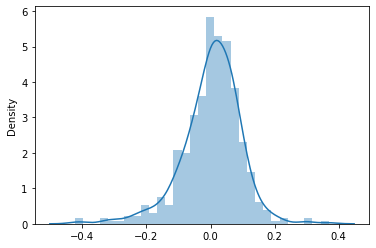

In [68]:
#The residue must be normally distributed hence checking the same using histogram
sns.distplot(residue)

***The distribution of residue looks Normally distributed***

##Predictions

In [69]:
#At first we need to rescale the training data set as per the scaling done on Training data set
#Variables to be rescaled
rescale_vars = ['atemp', 'hum', 'windspeed', 'cnt']

#Transform the test data set, from the fitting already done on training data set
df_test[rescale_vars] = scaler.transform(df_test[rescale_vars])
df_test = sm.add_constant(df_test)
df_test.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,const,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,...,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate,Fri,Mon,Sat,Sun,Thu,Tue,Wed
333,1.0,0.324343,0.632030,0.488582,0.413139,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203,1.0,1.013214,0.515242,0.185727,0.375403,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
279,1.0,0.594242,0.705024,-0.049804,0.570985,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
483,1.0,0.518402,0.604980,0.154750,0.722734,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
267,1.0,0.689572,0.870760,0.010767,0.573861,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [70]:
df_test.describe()

,const,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,...,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate,Fri,Mon,Sat,Sun,Thu,Tue,Wed
count,220.0,220.000000,220.000000,220.000000,220.000000,220.000000,220.000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,1.0,0.569385,0.652310,0.305077,0.529134,0.277273,0.250,0.245455,0.227273,0.459091,...,0.022727,0.650000,0.327273,0.140909,0.122727,0.163636,0.168182,0.136364,0.122727,0.145455
std,0.0,0.237294,0.141169,0.168920,0.221141,0.448673,0.434,0.431338,0.420026,0.499460,...,0.149373,0.478057,0.470288,0.348721,0.328872,0.370789,0.374881,0.343957,0.328872,0.353363
min,1.0,0.031559,0.311386,-0.049804,0.089623,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,0.385512,0.551846,0.185059,0.381040,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.0,0.599537,0.641738,0.283969,0.525311,0.000000,0.000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.0,0.761869,0.752576,0.406005,0.705476,1.000000,0.250,0.000000,0.000000,1.000000,...,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.0,1.064361,1.002146,0.800818,0.981707,1.000000,1.000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [71]:
# dividing the test data in predictor (X_test) and dependent (y_test) variables
X_test = df_test[lr_model.pvalues.reset_index().iloc[:,0].to_numpy()]
X_test.head()

,atemp,windspeed,Season_Spring,Season_Summer,Season_Winter,yr_2019,Aug,Dec,Jun,Nov,Sep,Holiday_Yes,Workingday_No,WeatherSit_Bad,WeatherSit_Moderate,Fri,Sun,Thu,Wed
333,0.324343,0.488582,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
203,1.013214,0.185727,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
279,0.594242,-0.049804,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
483,0.518402,0.154750,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
267,0.689572,0.010767,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [72]:
y_test = df_test['cnt']
y_test

333    0.413139
203    0.375403
279    0.570985
483    0.722734
267    0.573861
         ...   
574    0.756443
535    0.712034
290    0.543718
43     0.180281
707    0.368845
Name: cnt, Length: 220, dtype: float64

In [73]:
#predicting values for test data set
y_test_pred = lr_model.predict(X_test)

In [74]:
#Evaluating the predictions of test model
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7819298329340391

In [75]:
lr_model.params

atemp                  0.622242
windspeed             -0.083581
Season_Spring          0.028152
Season_Summer          0.102109
Season_Winter          0.181044
yr_2019                0.241447
Aug                    0.049001
Dec                   -0.019123
Jun                    0.031381
Nov                   -0.030826
Sep                    0.095919
Holiday_Yes           -0.088277
Workingday_No          0.047700
WeatherSit_Bad        -0.257033
WeatherSit_Moderate   -0.071398
Fri                    0.052396
Sun                   -0.050181
Thu                    0.043552
Wed                    0.032591
dtype: float64

***r2 score for test data set looks good. Hence it can be concluded that the current model is fitting the pattern.***

Testing the model with additional test data

In [76]:
df_train, df_test = train_test_split(df, train_size=0.7, random_state=30)
print(df_train.shape)
print(df_test.shape)

(510, 36)
(220, 36)


In [77]:
df_train[rescale_vars] = scaler.fit_transform(df_train[rescale_vars])
df_test[rescale_vars] = scaler.transform(df_test[rescale_vars])
df_test = sm.add_constant(df_test)
df_train.head()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,atemp,hum,windspeed,cnt,Season_Fall,Season_Spring,Season_Summer,Season_Winter,yr_2018,yr_2019,...,WeatherSit_Bad,WeatherSit_Good,WeatherSit_Moderate,Fri,Mon,Sat,Sun,Thu,Tue,Wed
155,0.690038,0.670951,0.239759,0.561896,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
108,0.513618,0.684661,0.279504,0.366084,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
493,0.601819,0.765210,0.399983,0.540152,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
405,0.242927,0.555270,0.194894,0.438219,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90,0.228951,0.705656,0.487178,0.253682,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
X_test = df_test[lr_model.pvalues.reset_index().iloc[:,0].to_numpy()]
X_test.head()

,atemp,windspeed,Season_Spring,Season_Summer,Season_Winter,yr_2019,Aug,Dec,Jun,Nov,Sep,Holiday_Yes,Workingday_No,WeatherSit_Bad,WeatherSit_Moderate,Fri,Sun,Thu,Wed
293,0.422794,0.410258,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
334,0.259520,0.407706,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
158,0.842846,0.235894,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
677,0.328484,0.396161,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
642,0.639390,0.173084,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [79]:
y_test = df_test['cnt']

y_test.head()

293    0.492637
334    0.426254
158    0.503797
677    0.686838
642    0.935803
Name: cnt, dtype: float64

In [80]:
y_test_pred = lr_model.predict(X_test)

In [81]:
r2_score(y_true=y_test, y_pred=y_test_pred)

0.7871643725021688